In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

In [3]:
# - set gray colormap and nearest neighbor interpolation by default
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['image.interpolation'] = 'nearest'

In [5]:
# - make numpy print numbers to 4dp only
np.set_printoptions(precision=4, suppress=True)

In [6]:
import nipy

In [7]:
img = nipy.load_image('ds114_sub009_t2r1.nii')
img.coordmap

AffineTransform(
   function_domain=CoordinateSystem(coord_names=('i', 'j', 'k', 't'), name='voxels', coord_dtype=float64),
   function_range=CoordinateSystem(coord_names=('scanner-x=L->R', 'scanner-y=P->A', 'scanner-z=I->S', 't'), name='scanner', coord_dtype=float64),
   affine=array([[  -4.    ,    0.    ,    0.    ,    0.    ,  124.244 ],
                 [   0.    ,    3.9345,    0.7207,    0.    , -103.4497],
                 [   0.    ,   -0.7207,    3.9346,    0.    ,  -33.4929],
                 [   0.    ,    0.    ,    0.    ,    2.5   ,    0.    ],
                 [   0.    ,    0.    ,    0.    ,    0.    ,    1.    ]])
)

In [8]:
data = img.get_data()

In [9]:
data.shape

(64, 64, 30, 173)

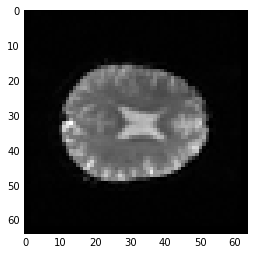

In [16]:
    plt.imshow(data[:, :, 15, 0])

In [12]:
from nipy.algorithms.diagnostics import screen, plot_tsdiffs

In [19]:
diagnostics = screen(img, slice_axis='k')

In [20]:
diagnostics.keys()

['std', 'min', 'max', 'ts_res', 'pca_res', 'pca', 'mean']

In [21]:
ts_res = diagnostics['ts_res']
ts_res.keys()

['slice_diff2_max_vol',
 'diff2_mean_vol',
 'volume_means',
 'slice_mean_diff2',
 'volume_mean_diff2']

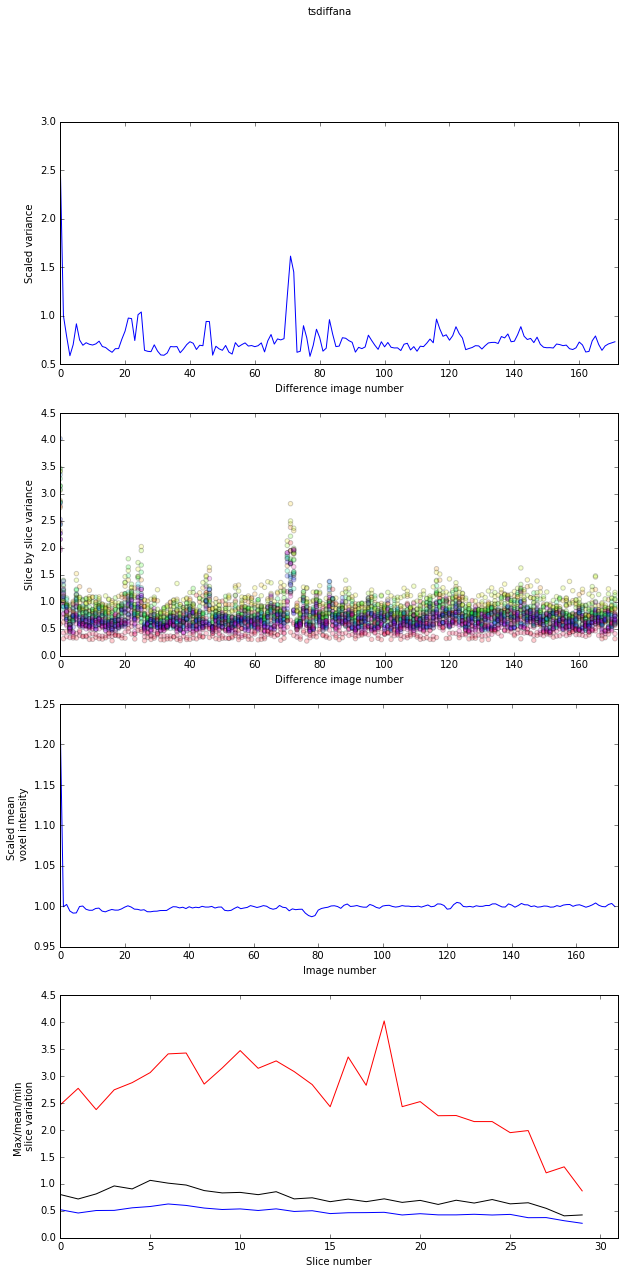

In [22]:
plt.figure(figsize=(10, 20))
axes = [plt.subplot(4, 1, i+1) for i in range(4)]
plot_tsdiffs(ts_res, axes)
plt.suptitle('tsdiffana')

In [23]:
pca_res = diagnostics['pca_res']
pca_res.keys()

['basis_vectors over 3',
 'axis',
 'basis_projections',
 'basis_vectors',
 'pcnt_var']

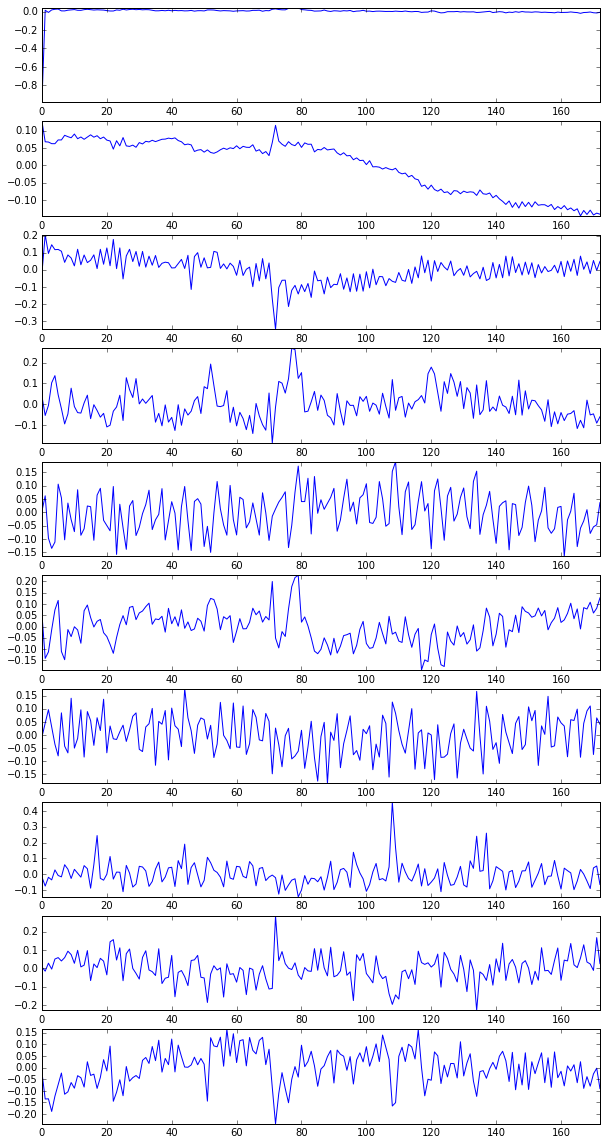

In [24]:
plt.figure(figsize=(10, 20))
n_comp = 10
for c in range(n_comp):
    plt.subplot(n_comp, 1, c+1)
    plt.plot(pca_res['basis_vectors'][:,c])
    plt.axis('tight')

In [25]:
projections = pca_res['basis_projections']
projections.shape

(64, 64, 30, 10)

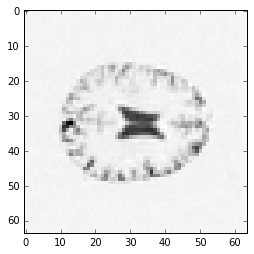

In [26]:
plt.imshow(projections.get_data()[:, :, 15, 0])

In [27]:
!nipy_diagnose ds114_sub009_t2r1.nii

/Users/mb312/.virtualenvs/nibabel/lib/python2.7/site-packages/nipy/io/files.py:145: FutureWarning: Default `strict` currently False; this will change to True in a future version of nipy
  ni_img = nipy2nifti(img, data_dtype = io_dtype)


In [28]:
ls *.png

components_ds114_sub009_t2r1.png  transformed_trans_0.png
pcnt_var_ds114_sub009_t2r1.png    transformed_trans_1.png
resampled_0.png                   transformed_trans_2.png
resampled_1.png                   tsdiff_ds114_sub009_t2r1.png
resampled_2.png


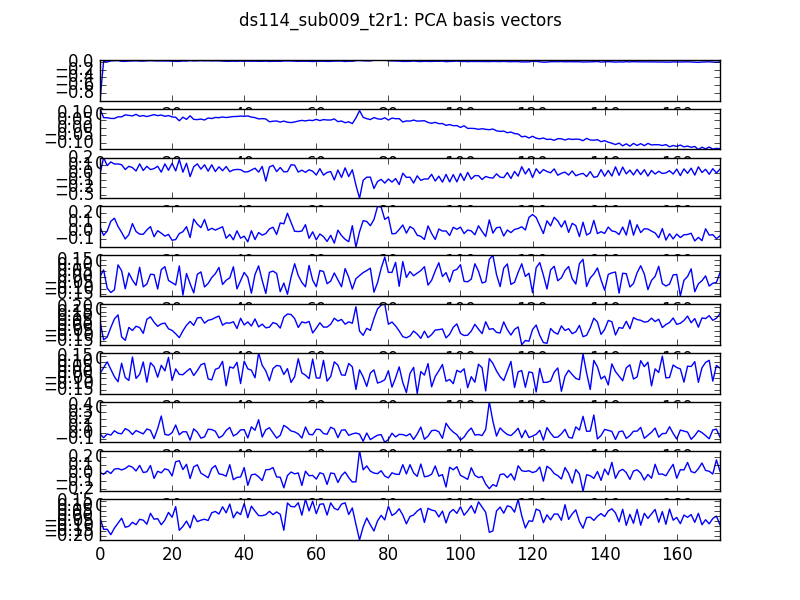

In [29]:
from IPython.display import Image
Image(filename='components_ds114_sub009_t2r1.png')

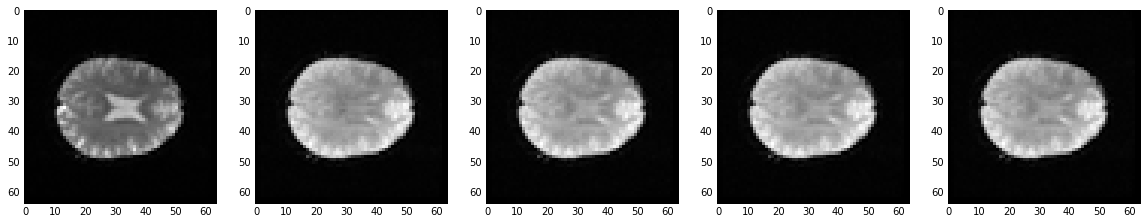

In [30]:
n_imgs = 5
fig, axes = plt.subplots(1, n_imgs, figsize=(20, 20))
for i in range(n_imgs):
    axes[i].imshow(data[:, :, 15, i])